In [ ]:
# run this for anthentic
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# for data science
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import warnings; warnings.filterwarnings(action='once')
import json
%matplotlib inline

In [ ]:
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from xgboost import plot_tree

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/local/lib/python3.6/dist-packages/_pytest/mark/structures.py:426: DeprecationWarning: The usage of `cmp` is deprecated and will be removed on or after 2021-06-01.  Please use `eq` and `order` instead.
  @attr.s(cmp=False, hash=False)


In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
# file_list = drive.ListFile({'q': "'root' in parents and trashed=false"}).GetList()
# for file1 in file_list:
#   print('title: %s, id: %s, mimeType: %s' % (file1['title'], file1['id'], file1["mimeType"]))
cdc_list = drive.ListFile({'q': "'144fnA-4uAmg9DXgqwH-cIpr2pGiaa_gk' in parents"}).GetList()
for _file in cdc_list:
  print('title: %s, id: %s, mimeType: %s' % (_file['title'], _file['id'], _file["mimeType"]))
# print('connection succeed')

/usr/local/lib/python3.6/dist-packages/google/colab/auth.py:144: ResourceWarning: unclosed <ssl.SSLSocket fd=76, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.2', 34732), raddr=('64.233.189.84', 443)>
  if not _check_adc():
/usr/local/lib/python3.6/dist-packages/google/colab/auth.py:160: ResourceWarning: unclosed <ssl.SSLSocket fd=76, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.2', 43972), raddr=('108.177.97.84', 443)>
  if _check_adc():


title: Step III: Multi-class classification Model.ipynb, id: 1tmdCi_2yIfngpR2ETL1qbllc6F1-VHb_, mimeType: application/vnd.google.colaboratory
title: CDC mortality research paper, id: 1Kutx-oqnP7FkP0sxGqffcsNzlhyfwHwad4fI6YxlMao, mimeType: application/vnd.google-apps.document
title: Step IV: NLP for Medical Transcript.ipynb, id: 1JSPF2LKbLpgjwABQOlDjfPbpdiigBKjW, mimeType: application/vnd.google.colaboratory
title: Step  II: Further Analysis and Preliminary Model.ipynb, id: 1mhTMTw8KStxotzcR0X6e28o2UqcWiPTi, mimeType: application/vnd.google.colaboratory
title: Step I: Data preprocessing and Data Preliminary Analysis.ipynb, id: 1lxoWVX-07xYu3j1TQ0HIMuAjOdZjgkrv, mimeType: application/vnd.google.colaboratory
title: Useless.ipynb, id: 1-7ldIE79aFkHryd9OallyZMwCOSBO7K4, mimeType: application/vnd.google.colaboratory
title: CDC final report, id: 1lnRm3RNyNlrsGRXLQytyKkANMEYa6vfAifNT-s16-S8, mimeType: application/vnd.google-apps.presentation
title: CDC Mortality Research Preliminary Report, id

In [ ]:
#import the model data
f_cdc = drive.CreateFile({'id':'1DNSbsqMccZBRlWam-dG38Q6pmtWfaqb3'})
f_cdc.GetContentFile('cdc.csv')
chunks=pd.read_csv('cdc.csv',chunksize=1000000)
cdc_df = pd.concat(chunks)

/usr/lib/python3.6/ssl.py:651: ResourceWarning: unclosed <ssl.SSLSocket fd=82, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.2', 53188), raddr=('74.125.23.95', 443)>
  return self._sslobj.peer_certificate(binary_form)
/usr/local/lib/python3.6/dist-packages/pandas/core/dtypes/common.py:219: ResourceWarning: unclosed <ssl.SSLSocket fd=80, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.2', 33856), raddr=('74.125.203.95', 443)>
  return lambda tipo: (


In [ ]:
cdc_df.head()

,Unnamed: 0,resident_status,month_of_death,sex,is_infant,place_of_death_and_decedents_status,marital_status,day_of_week_of_death,current_data_year,injury_at_work,method_of_disposition,autopsy,activity_code,place_of_injury_for_causes_w00_y34_except_y06_and_y07_,race,icd_code_10th_revision,education,age
0,0,1,1,F,0,1,M,2,2005,U,U,N,NaN,NaN,1,C439,2.0,45.0
1,1,1,1,M,0,1,D,7,2005,U,U,N,NaN,NaN,1,J439,4.0,61.0
2,2,1,1,F,0,6,D,1,2005,U,U,N,NaN,NaN,1,I698,3.0,79.0
3,3,1,1,M,0,1,S,4,2005,U,U,N,NaN,NaN,1,E119,3.0,50.0
4,4,1,1,F,0,1,M,2,2005,U,U,N,NaN,NaN,1,C349,4.0,68.0


In [ ]:
cdc_df.shape

(27720673, 18)

In [ ]:
cdc_df.describe()

,Unnamed: 0,resident_status,month_of_death,is_infant,place_of_death_and_decedents_status,day_of_week_of_death,current_data_year,activity_code,place_of_injury_for_causes_w00_y34_except_y06_and_y07_,race,education,age
count,2.772067e+07,2.772067e+07,2.772067e+07,2.772067e+07,2.772067e+07,2.772067e+07,2.772067e+07,2.042056e+06,1.945947e+06,2.772067e+07,2.772067e+07,2.772067e+07
mean,1.261659e+06,1.226439e+00,6.432601e+00,1.023305e-02,3.542366e+00,4.011841e+00,2.010104e+03,8.976341e+00,3.843905e+00,1.634277e+00,3.511437e+00,7.292481e+01
std,7.303525e+05,5.013507e-01,3.520570e+00,1.006396e-01,2.151926e+00,2.003231e+00,3.179808e+00,4.143830e-01,4.129943e+00,5.115081e+00,1.930670e+00,2.158298e+01
min,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,2.005000e+03,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00
25%,6.300150e+05,1.000000e+00,3.000000e+00,0.000000e+00,1.000000e+00,2.000000e+00,2.007000e+03,9.000000e+00,0.000000e+00,1.000000e+00,2.000000e+00,6.300000e+01
50%,1.260030e+06,1.000000e+00,6.000000e+00,0.000000e+00,4.000000e+00,4.000000e+00,2.010000e+03,9.000000e+00,1.000000e+00,1.000000e+00,3.000000e+00,7.700000e+01
75%,1.890045e+06,1.000000e+00,1.000000e+01,0.000000e+00,6.000000e+00,6.000000e+00,2.013000e+03,9.000000e+00,9.000000e+00,1.000000e+00,4.000000e+00,8.600000e+01
max,2.718197e+06,4.000000e+00,1.200000e+01,1.000000e+00,9.000000e+00,9.000000e+00,2.015000e+03,9.000000e+00,9.000000e+00,7.800000e+01,9.000000e+00,9.990000e+02


In [ ]:
cdc_df.columns

Index(['Unnamed: 0', 'resident_status', 'month_of_death', 'sex', 'is_infant',
       'place_of_death_and_decedents_status', 'marital_status',
       'day_of_week_of_death', 'current_data_year', 'injury_at_work',
       'method_of_disposition', 'autopsy', 'activity_code',
       'place_of_injury_for_causes_w00_y34_except_y06_and_y07_', 'race',
       'icd_code_10th_revision', 'education', 'age'],
      dtype='object')

In [ ]:
cdc_df['place_of_death_and_decedents_status'].unique()

array([1, 6, 7, 4, 2, 3, 9, 5])

In [ ]:
predictors = ['resident_status', 'month_of_death', 'sex', 'is_infant', 'marital_status',
       'current_data_year', 'race','education', 'age']
       # 'icd_code_10th_revision'

In [ ]:
for pred in predictors:
  print(cdc_df[pred].unique())

[1 3 2 4]
[ 1  2  3  4  5  6  7  8  9 10 11 12]
['F' 'M']
[0 1]
['M' 'D' 'S' 'W' 'U']
[2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015]
['U' 'N' 'Y']
[ 1  3  2 68  7  5  4  6 18 78 48 28 38 58]
[2. 4. 3. 1. 7. 9. 6. 5. 8.]
[4.5000000e+01 6.1000000e+01 7.9000000e+01 5.0000000e+01 6.8000000e+01
 8.9000000e+01 7.3000000e+01 8.5000000e+01 9.3000000e+01 7.7000000e+01
 7.8000000e+01 4.8000000e+01 5.9000000e+01 3.9000000e+01 6.4000000e+01
 9.0000000e+01 8.1000000e+01 3.3000000e+01 6.3000000e+01 4.6000000e+01
 6.9000000e+01 7.6000000e+01 7.5000000e+01 9.4000000e+01 8.3000000e+01
 7.1000000e+01 5.5000000e+01 9.2000000e+01 4.3000000e+01 6.7000000e+01
 5.8000000e+01 8.0000000e+01 6.6000000e+01 2.1000000e+01 3.6000000e+01
 7.6100000e-05 4.9000000e+01 1.6666667e-01 7.4000000e+01 7.2000000e+01
 3.1000000e+01 2.7000000e+01 8.4000000e+01 9.1000000e+01 5.2000000e+01
 8.7000000e+01 9.5000000e+01 4.4000000e+01 4.7000000e+01 5.7000000e+01
 5.3000000e+01 8.2000000e+01 6.0000000e+01 5.1000000e+01 8.8

In [ ]:
change_type = ['sex','marital_status','current_data_year','race'] #'injury_at_work','method_of_disposition','autopsy'
for p in change_type:
  cdc_df[p] = cdc_df[p].astype('category').cat.codes

In [ ]:
target_dict = {
'I251':0,
'C349':1,
'I219':2,
'J449':3,
'F03': 4,
'G309':5,
'I64': 6,
'I250':7,
'I500':8,
'J189':9}

In [ ]:
def y_encoding(x):
  if x in target_dict.keys():
    return target_dict[x]
  else:
    return 10

In [ ]:
cdc_df['target_icd']=cdc_df['icd_code_10th_revision'].apply(y_encoding)

In [ ]:
other_icd = cdc_df['target_icd']==10
other_df = cdc_df[other_icd]
top10_df = cdc_df[~other_icd]

In [ ]:
other_df.shape

(17056735, 19)

In [ ]:
top10_df.shape

(10663938, 19)

In [ ]:
down_sample = other_df.sample(n=1066394, replace=True)
#frac=?,

In [ ]:
down_sample.shape

(1066394, 19)

In [ ]:
cdc_df=pd.concat([top10_df,down_sample])

In [ ]:
cdc_df.shape

(11730332, 19)

In [ ]:
train,test = train_test_split(cdc_df, shuffle=True, random_state=38)

In [ ]:
train_x,train_y  = train[predictors], train['target_icd']
test_x, test_y = test[predictors], test['target_icd']

In [ ]:
test_y.shape

(2932583,)

In [ ]:
test_y.shape

(2932584,)

In [ ]:
train_y.describe()

count    8.797749e+06
mean     3.909347e+00
std      3.249048e+00
min      0.000000e+00
25%      1.000000e+00
50%      3.000000e+00
75%      6.000000e+00
max      1.000000e+01
Name: target_icd, dtype: float64

In [ ]:
test_y.describe()

count    2.932583e+06
mean     3.911033e+00
std      3.250157e+00
min      0.000000e+00
25%      1.000000e+00
50%      3.000000e+00
75%      6.000000e+00
max      1.000000e+01
Name: target_icd, dtype: float64

In [ ]:
params = {}
params['num_class'] = 11
params["objective"] = "multi:softprob"
#params["eval_metric"] = "logloss"
#params["eta"] = 0.02
#params["gamma"] = 0.1
#params["tree_method"] = "gpu_hist"
#params["max_depth"] = 6
#params["min_child_weight"] = 4
#params["max_bin"] = 256
#params["subsample"] = 0.8
#params["colsample_bytree"] = 0.9

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import MultiLabelBinarizer
import xgboost as xgb

#clf = OneVsRestClassifier(XGBClassifier(params))

# You may need to use MultiLabelBinarizer to encode your variables from arrays [[x, y, z]] to a multilabel 
# format before training.
#mlb = MultiLabelBinarizer()
#train_y = mlb.fit_transform(train_y)

#clf.fit(train_x, train_y)

In [ ]:
xgbc = xgb.XGBClassifier(learning_rate=0.5,
                    n_estimators=150,
                    max_depth=6,
                    min_child_weight=0,
                    gamma=0,
                    reg_lambda=1,
                    subsample=1,
                    colsample_bytree=0.75,
                    scale_pos_weight=1, 
                    objective='multi:softprob',
                    num_class=11,
                    random_state=42,
                    tree_method='gpu_hist')

mcl = xgbc.fit(train_x, train_y, eval_metric='mlogloss')

In [ ]:
mcl.feature_importances_

array([0.02196866, 0.00398746, 0.08613262, 0.4609027 , 0.05426782,
       0.01715067, 0.12574935, 0.01618592, 0.0176732 , 0.19598156],
      dtype=float32)

In [ ]:
predictors

['resident_status',
 'month_of_death',
 'sex',
 'is_infant',
 'marital_status',
 'current_data_year',
 'injury_at_work',
 'race',
 'education',
 'age']

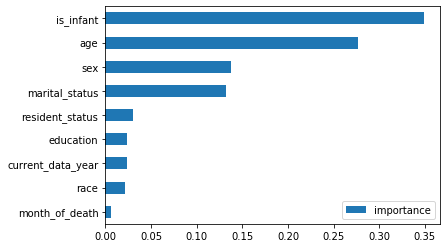

In [ ]:
rank = pd.DataFrame({'importance':mcl.feature_importances_,'Variables':predictors},index=predictors).sort_values(by='importance',ascending=True)
ax=rank.plot.barh()

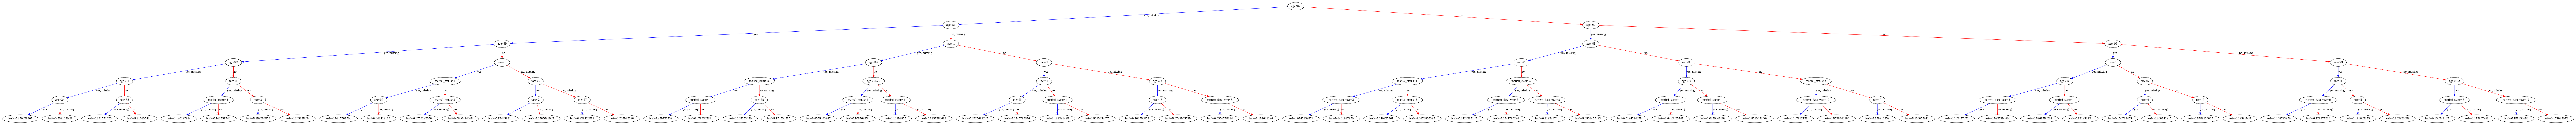

In [ ]:
fig, ax = plt.subplots(figsize=(500, 10))
xgb.plot_tree(mcl, num_trees=3, ax=ax)
plt.show()

In [ ]:
test_predict = mcl.predict(test_x)

In [ ]:
accuracy_score(test_y,test_predict)

ValueError: ignored

In [ ]:
test_predict

array([4, 1, 2, ..., 5, 0, 1])

In [ ]:
type(test_y)

pandas.core.series.Series

In [ ]:
result = pd.DataFrame({'real':test_y.values,'predict':test_predict},index=test_y.index)

In [ ]:
result

,real,predict
17277037,4,4
9573191,2,1
3258771,10,2
13394564,5,0
15316087,3,3
...,...,...
24597552,8,3
25161554,5,0
9635122,10,5
23562055,10,0


In [ ]:
result[result['predict']==result['real']].shape[0]/2932583

0.23248037651449252